<a href="https://colab.research.google.com/github/YossefMohamed/Detecting-COVID-19-Through-Sound/blob/main/Machine_learning_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import csv
import shutil
import os
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential,Model
from keras.layers import concatenate,Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from sklearn.metrics import roc_curve
from keras.utils import np_utils
from tqdm import tqdm
import pandas as pd
import numpy as np
import librosa 
import librosa.display
import pylab
import cv2

In [ ]:
!wget https://zenodo.org/record/4498364/files/public_dataset.zip?download=1
# https://zenodo.org/record/4048312/files/public_dataset.zip?download=1 (older version of ds)
!mv public_dataset.zip?download=1 public_dataset.zip
!unzip -q public_dataset.zip

--2022-06-07 17:14:08--  https://zenodo.org/record/4498364/files/public_dataset.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1332806163 (1.2G) [application/octet-stream]
Saving to: ‘public_dataset.zip?download=1’

public_dataset.zip? 100%[===================>]   1.24G  3.61MB/s    in 5m 16s  

2022-06-07 17:19:26 (4.02 MB/s) - ‘public_dataset.zip?download=1’ saved [1332806163/1332806163]



In [ ]:
c=0
j=0
o=0
for file in os.listdir('public_dataset'):
    if file.endswith(".webm") :
        c+=1
        
    if file.endswith(".json") :
       j+=1
    if file.endswith(".ogg") :
       o+=1
print("no of .webm files  " +str(c))
print("no of .json files  "+str(j))
print("no of .ogg files   "+str(o))

no of .webm files  25985
no of .json files  27550
no of .ogg files   1565


In [ ]:
count=0
webm_count=0
covid_samples_count=0
reduced=0
bad=0

selected_filenames=[]
coughvid_webm_files=[]

for file in os.listdir('public_dataset'):
    if file.endswith(".json"):
        count+=1
        
        path=os.path.join('public_dataset',file)
        
        f=open(path,"r")
        data=json.loads(f.read())
        
        if float(data['cough_detected'])>0.9:
            if 'status' in data:
                if(data['status']=='COVID-19'):
                    covid_samples_count+=1

                    if 'expert_labels_1' in data:
                        if(data['expert_labels_1']['quality']=='ok' or data['expert_labels_1']['quality']=='good'):
                            reduced+=1
                            selected_filenames.append(path)
                    elif 'expert_labels_2' in data:
                        if(data['expert_labels_2']['quality']=='ok' or data['expert_labels_2']['quality']=='good'):
                            reduced+=1
                            selected_filenames.append(path)
                    elif 'expert_labels_3' in data:
                        if(data['expert_labels_3']['quality']=='ok' or data['expert_labels_3']['quality']=='good'):
                            reduced+=1
                            selected_filenames.append(path)
                    else:
                        reduced+=1
                        selected_filenames.append(path)
        if file.endswith(".webm") :
           coughvid_webm_files.append(file)


In [ ]:
#print(selected_filenames)
print(len(selected_filenames))

438


In [ ]:
print("Total Number of samples :",count)
print("\nTotal Number of COVID-19 samples with cough_detected score>0.9 :",covid_samples_count)
print("\nExpert labeled COVID-19 samples with quality good/ok OR not expert labelled :",reduced)

Total Number of samples : 27550

Total Number of COVID-19 samples with cough_detected score>0.9 : 499

Expert labeled COVID-19 samples with quality good/ok OR not expert labelled : 438


Save +ve

In [ ]:
coughvid  = '/content/public_dataset/'
VidData   = pd.read_csv(os.path.join(coughvid,'metadata_compiled.csv'),header=0)
VidData   = VidData.loc[VidData['cough_detected'] >= 0.9][['uuid','fever_muscle_pain','respiratory_condition','status']]
VidData.dropna(inplace=True)

coughvid_positive = VidData.loc[VidData['status']=='COVID-19']
'''coughvid_negative = VidData.loc[VidData['status']!='COVID-19'] [0:1200]
'''
coughvid_positive['DIR'] = coughvid + coughvid_positive['uuid'] + '.webm'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
coughvid_positive.head()

,uuid,fever_muscle_pain,respiratory_condition,status,DIR
140,015576c8-2b03-4dcb-b251-78a984fe86fe,False,False,COVID-19,/content/public_dataset/015576c8-2b03-4dcb-b25...
155,0177b817-0ba3-498a-bc05-48bc66cc91b8,False,False,COVID-19,/content/public_dataset/0177b817-0ba3-498a-bc0...
158,01820f7c-b953-4faf-aa13-978cfda6b08e,False,False,COVID-19,/content/public_dataset/01820f7c-b953-4faf-aa1...
177,01bf156f-a8ff-48f6-9335-8a1f5bb4c1b7,False,False,COVID-19,/content/public_dataset/01bf156f-a8ff-48f6-933...
272,02aa80ef-a83b-477f-b01d-575651364b22,True,False,COVID-19,/content/public_dataset/02aa80ef-a83b-477f-b01...


In [ ]:
!mkdir coughvidpos

In [ ]:
for i in coughvid_positive ['DIR']:
  name=os.path.splitext(i)[0]
  if os.path.exists(name+'.webm'):
    filepath=name+'.webm'
    shutil.copy(filepath,'/content/coughvidpos')
  else:   
    filepath=name+'.ogg'
    shutil.copy(filepath,'/content/coughvidpos')


In [ ]:
len([file for file in os.listdir('/content/coughvidpos')])

699

In [ ]:
!mkdir coughvidnegative
healthy_samples=0
reduced=0
paths=[]

for file in os.listdir('public_dataset'):
    if file.endswith(".json"):
        
        path=os.path.join('public_dataset',file)
        
        f=open(path,"r")
        data=json.loads(f.read())
        
        if float(data['cough_detected'])>0.9:
            if 'status' in data:
                if(data['status']=='healthy'):
                    healthy_samples+=1

                    if 'expert_labels_1' in data:
                        if((data['expert_labels_1']['quality']=='ok' or data['expert_labels_1']['quality']=='good')):
                            reduced+=1
                            paths.append(path)
                    elif 'expert_labels_2' in data:
                        if((data['expert_labels_2']['quality']=='ok' or data['expert_labels_2']['quality']=='good')):
                            reduced+=1
                            paths.append(path)
                    elif 'expert_labels_3' in data:
                        if((data['expert_labels_3']['quality']=='ok' or data['expert_labels_3']['quality']=='good')):
                            reduced+=1
                            paths.append(path)
                    else:
                        reduced+=1
                        paths.append(path)
                        
    if reduced==1387:
        break

In [ ]:
print("Number of healthy cough sound samples considered : ",reduced)

Number of healthy cough sound samples considered :  1387


In [ ]:

cougvidnegative = '/content/coughvidnegative'
for i in paths:
    name=os.path.splitext(i)[0]
    if os.path.exists(name+'.webm'):
      filepath=name+'.webm'
      shutil.copy(filepath,cougvidnegative)
    else:   
     filepath=name+'.ogg'
     shutil.move(filepath,cougvidnegative)


In [ ]:

len([file for file in os.listdir('/content/coughvidnegative')])
 

1387

In [ ]:
!mkdir val train test
!mkdir COVID HEALTHY
!mkdir val/COVID 
!mkdir val/HEALTHY
!mkdir test/COVID 
!mkdir test/HEALTHY
!mkdir train/COVID 
!mkdir train/HEALTHY

In [ ]:
import soundfile as sf
for filename in os.listdir('/content/coughvidpos'):
        samples, sr= librosa.load('/content/coughvidpos/'+filename, sr=22050)
        audio_file=  filename.split("/")[-1][0:-5]
        sf.write ('/content/COVID/'+audio_file+'.wav',samples,sr)
 

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/cor

In [ ]:
len([file for file in os.listdir('COVID')])

699

In [ ]:
for filename in tqdm(os.listdir('/content/coughvidnegative')):
        samples, sr = librosa.load('/content/coughvidnegative/'+filename, sr=sr)
        audio_file=  filename.split("/")[-1][0:-5]
        sf.write ('/content/HEALTHY/'+audio_file+'.wav',samples,sr)

  0%|          | 0/1387 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 1/1387 [00:00<09:32,  2.42it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 2/1387 [00:00<10:20,  2.23it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 3/1387 [00:01<12:08,  1.90it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 4/1387 [00:02<13:42,  1.68it/s]/usr/loc

In [ ]:
len([file for file in os.listdir('HEALTHY')])

1387

In [ ]:
!pip install audiomentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 71 kB 3.6 MB/s 


In [ ]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import soundfile as sf

In [ ]:
!mkdir augmented_covid_data
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])
sets = '/content/COVID'
augmented_data= '/content/augmented_covid_data'
for audio_file in tqdm(os.listdir(sets)):
        samples, sr = librosa.load(sets+'/'+audio_file)
        augmented_sample = augment(samples=samples, sample_rate=sr)
        sf.write(augmented_data+'/aug_'+audio_file, augmented_sample, sr)

100%|██████████| 699/699 [02:38<00:00,  4.40it/s]


In [ ]:
#number of  augmented covid samples
len([file for file in os.listdir('/content/augmented_covid_data')])

699

In [ ]:
!git clone https://github.com/iiscleap/Coswara-Data.git

Cloning into 'Coswara-Data'...
remote: Enumerating objects: 798, done.
remote: Total 798 (delta 0), reused 0 (delta 0), pack-reused 798
Receiving objects: 100% (798/798), 15.97 GiB | 57.31 MiB/s, done.
Resolving deltas: 100% (310/310), done.
Checking out files: 100% (202/202), done.


In [ ]:
rt_dir = '/content/Coswara-Data'
import glob
for each in os.listdir(rt_dir):
    if os.path.isdir(os.path.join(rt_dir,each)) and each != '.git':
        print(each)
        !cat {os.path.join(rt_dir, each,'')}*.tar.gz.* > {os.path.join(rt_dir, each,'')}combined_file.tar.gz
        !tar -xzf {os.path.join(rt_dir, each,'')}combined_file.tar.gz -C {rt_dir}
subset = glob.glob('/content/Coswara-Data/*/*.tar.gz.*') + glob.glob('/content/Coswara-Data/*/combined_data.tar.gz')
[os.remove(x) for x in subset];

20200430
cat: '/content/Coswara-Data/20200430/*.tar.gz.*': No such file or directory

gzip: stdin: unexpected end of file
tar: Child returned status 1
tar: Error is not recoverable: exiting now
20200930
cat: '/content/Coswara-Data/20200930/*.tar.gz.*': No such file or directory

gzip: stdin: unexpected end of file
tar: Child returned status 1
tar: Error is not recoverable: exiting now
20210816
cat: '/content/Coswara-Data/20210816/*.tar.gz.*': No such file or directory

gzip: stdin: unexpected end of file
tar: Child returned status 1
tar: Error is not recoverable: exiting now
20200707
cat: '/content/Coswara-Data/20200707/*.tar.gz.*': No such file or directory

gzip: stdin: unexpected end of file
tar: Child returned status 1
tar: Error is not recoverable: exiting now
20200901
cat: '/content/Coswara-Data/20200901/*.tar.gz.*': No such file or directory

gzip: stdin: unexpected end of file
tar: Child returned status 1
tar: Error is not recoverable: exiting now
20200502
cat: '/content/Coswar

In [ ]:
healthy_count=0
covid_pos_count=0
with open('/content/Coswara-Data/combined_data.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        COVID_STATUS=row[2]
        if(COVID_STATUS=='healthy' or COVID_STATUS=='resp_illness_not_identified' or COVID_STATUS=='no_resp_illness_exposed' or COVID_STATUS== 'recovered_full'):
            healthy_count+=1
        elif(COVID_STATUS=='positive_mild' or COVID_STATUS=='positive_asymp' or COVID_STATUS=='positive_moderate'):
            covid_pos_count+=1
    
print("Healthy => ",healthy_count," Covid => ",covid_pos_count)

Healthy =>  1984  Covid =>  681


In [ ]:
from operator import length_hint
names   = ['ID','STATUS','DIR','DataSet']
join_by = pd.read_csv('/content/Coswara-Data/combined_data.csv')

import glob
df_list = []
for path in tqdm(glob.glob('/content/Coswara-Data/*/*/cough-shallow.wav')):
  temp = pd.DataFrame(columns=['id','DIR'])
  temp['id'] = [path.split('/')[-2]]
  temp['DIR'] = [path]
  temp = pd.merge(left=temp,right=join_by,on='id',how='inner')
  temp        = temp[['id','covid_status','DIR']]
  df_list.append(temp.rename(columns={'id':'ID','covid_status':'STATUS','DIR':'DIR'}))
CosData1=pd.concat(df_list)
CosData1['DataSet'] = 'coswara'
CosData1.head()

100%|██████████| 2745/2745 [00:23<00:00, 114.86it/s]


,ID,STATUS,DIR,DataSet
0,fci4w1K0PXhKOJfLlv6dql3YRU23,no_resp_illness_exposed,/content/Coswara-Data/20200430/fci4w1K0PXhKOJf...,coswara
0,DRBAZX64nuVtqBQf13gH7r36Mh52,healthy,/content/Coswara-Data/20200430/DRBAZX64nuVtqBQ...,coswara
0,xKW2EpGmJcfigLecUTLVXEWQHPg2,healthy,/content/Coswara-Data/20200430/xKW2EpGmJcfigLe...,coswara
0,vulAApAIpgcosLjfJtaN7Rrp2jo2,healthy,/content/Coswara-Data/20200430/vulAApAIpgcosLj...,coswara
0,Jw7YMfwGqMX22UbHh1TTgYMTYWs1,healthy,/content/Coswara-Data/20200430/Jw7YMfwGqMX22Ub...,coswara


In [ ]:
CosData1['STATUS'].unique()

array(['no_resp_illness_exposed', 'healthy',
       'resp_illness_not_identified', 'positive_mild', 'recovered_full',
       'positive_asymp', 'positive_moderate', 'under_validation'],
      dtype=object)

In [ ]:
!mkdir coswara_COVID
for index, row in CosData1.iterrows():
  COVID_STATUS=row[1]  
  if(COVID_STATUS=='positive_mild' or COVID_STATUS=='positive_asymp' or COVID_STATUS=='positive_moderate'):
     try:
      shutil.copy(row[2],'/content/coswara_COVID/'+row[0]+'-s-'+'.wav')
      
     except:
      
        print("file not found")

In [ ]:
#this a stupid way to resample, fixing it later
!mkdir COSWARA_COVID_SAMPLES
for filename in os.listdir('/content/coswara_COVID'):
   try:
        samples, sr = librosa.load('/content/coswara_COVID/'+filename, sr=sr)
        sf.write ('/content/COSWARA_COVID_SAMPLES/'+filename,samples,sr)
   except:
    print("file too small")

file too small
file too small
file too small


In [ ]:
len([file for file in os.listdir('/content/COSWARA_COVID_SAMPLES/')])

678

In [ ]:

for i in os.listdir('/content/COSWARA_COVID_SAMPLES'):
  print( librosa.get_samplerate('/content/COSWARA_COVID_SAMPLES/' +i))

22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
2205

In [ ]:
!mkdir coswara_HEALTHY
c=0
for index, row in CosData1.iterrows():
  COVID_STATUS=row[1]  
  if(COVID_STATUS=='healthy'):
     try:
      shutil.copy(row[2],'/content/coswara_HEALTHY/'+row[0]+'-s-'+'.wav')
      c=c+1
      if c==1387:
        break
     except:
      
        print("file not found")

In [ ]:
c=0
for i in os.listdir('/content/coswara_HEALTHY/'):
  c=c+1
c

1387

In [ ]:
#this a stupid way to resample, fixing it later
!mkdir COSWARA_HEALTHY_SAMPLES
for filename in os.listdir('/content/coswara_HEALTHY'):
   try:
        samples, sr = librosa.load('/content/coswara_HEALTHY/'+filename, sr=sr)
        sf.write ('/content/COSWARA_HEALTHY_SAMPLES/'+filename,samples,sr)
   except:
    print("file too small")
shutil.rmtree('/content/coswara_HEALTHY')

file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small
file too small


In [ ]:
for file in os.listdir('/content/COSWARA_HEALTHY_SAMPLES'):
    shutil.move('/content/COSWARA_HEALTHY_SAMPLES/'+ file, '/content/HEALTHY/')

In [ ]:
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])
sets = '/content/COSWARA_COVID_SAMPLES'
for audio_file in tqdm(os.listdir(sets)):
  try:
     samples, sr = librosa.load(sets+'/'+audio_file)
     augmented_sample = augment(samples=samples, sample_rate=sr)
     sf.write('/content/augmented_covid_data'+'/coswara_aug_'+audio_file, augmented_sample, sr)

  except:
    print("\n File can't open")

100%|██████████| 678/678 [01:26<00:00,  7.83it/s]


In [ ]:
len([file for file in os.listdir('/content/augmented_covid_data')])

1377

In [ ]:
for file in tqdm(os.listdir('/content/COSWARA_COVID_SAMPLES')):
    shutil.copy('/content/COSWARA_COVID_SAMPLES/'+ file, '/content/COVID/')

100%|██████████| 678/678 [00:00<00:00, 1216.24it/s]


In [ ]:
for file in tqdm(os.listdir('/content/augmented_covid_data')):
    shutil.copy('/content/augmented_covid_data/'+ file, '/content/COVID/')

100%|██████████| 1377/1377 [00:05<00:00, 233.57it/s]


In [ ]:
len([file for file in os.listdir('/content/COVID')])

2754

In [ ]:
len([file for file in os.listdir('HEALTHY')])

2746

In [ ]:
num=0
for file in os.listdir('COVID'):
    num+=1
    if num<=275:
        shutil.copy('/content/COVID/'+file,'/content/test/COVID/'+file)
    else:
        shutil.copy('/content/COVID/'+file,'/content/train/COVID/'+file)
        


In [ ]:
num=0
for file in os.listdir('HEALTHY'):
    num+=1
    if num<= 274:
        shutil.copy('/content/HEALTHY/'+file,'/content/test/HEALTHY/'+file)
    else:
        shutil.copy('/content/HEALTHY/'+file,'/content/train/HEALTHY/'+file)

In [ ]:

print(" train/COVID =>",len([file for file in os.listdir('train/COVID')]))
print(" test/COVID =>",len([file for file in os.listdir('test/COVID')]))


print(" train/healthy =>",len([file for file in os.listdir('train/HEALTHY')]))
print(" test/healthy =>",len([file for file in os.listdir('test/HEALTHY')]))


 train/COVID => 2479
 test/COVID => 275
 train/healthy => 2472
 test/healthy => 274


In [ ]:
!pip install pyAudioAnalysis

In [ ]:
!pip install eyed3

In [ ]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pyAudioAnalysis import audioTrainTest as aT

#KNN

In [ ]:
aT.extract_features_and_train(['train/COVID','train/HEALTHY'], 1.0, 1.0, aT.shortTermWindow, aT.shortTermStep, "knn", "knn_model", use_smote=True)

Streaming output truncated to the last 5000 lines.
Analyzing file 59 of 2479: train/COVID/1510dd92-a632-48ad-b5e7-1853a9e8e61d.wav
Analyzing file 60 of 2479: train/COVID/154161ff-1243-49c0-a377-72992b6954e3.wav
Analyzing file 61 of 2479: train/COVID/15a0a034-354e-4637-b74c-9653763e0862.wav
Analyzing file 62 of 2479: train/COVID/15f12b8d-7ba5-444e-975f-f1b26c6e75ae.wav
Analyzing file 63 of 2479: train/COVID/16f9b161-86c6-4af1-99cb-0ab327f10fed.wav
Analyzing file 64 of 2479: train/COVID/17b54f0d-2f96-4f6d-ae52-ac2e31bcc692.wav
Analyzing file 65 of 2479: train/COVID/17e623e8-7179-4805-889b-83ba37063d21.wav
Analyzing file 66 of 2479: train/COVID/17ff41b3-1ac5-4689-b5f1-056851201c26.wav
Analyzing file 67 of 2479: train/COVID/182246b0-9f77-4c40-976e-3c9342619819.wav
Analyzing file 68 of 2479: train/COVID/1853c64d-a058-471d-8409-84fd2afb5edd.wav
Analyzing file 69 of 2479: train/COVID/18c36541-7566-4f46-8264-3716e2e71f30.wav
Analyzing file 70 of 2479: train/COVID/18e49b6e-60e4-4eb1-8de8-e82615

In [ ]:
import plotly
import plotly.subplots
import seaborn as sn
import matplotlib.pyplot as plt

[[173 102]
 [ 64 210]]
[0.6290909090909091, 0.7664233576642335] [0.729957805907173, 0.6730769230769231] [0.67578125, 0.7167235494880545] 0.6962523997440273 0.697632058287796


Text(60.0, 0.5, 'Truth value')

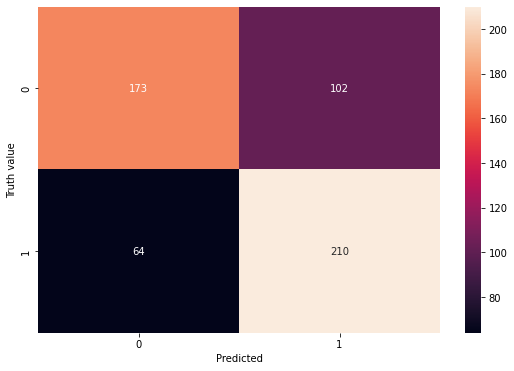

In [ ]:
cm, thr_prre, pre, rec, thr_roc, fpr, tpr = aT.evaluate_model_for_folders(["test/COVID","test/HEALTHY"], "knn_model", "knn","COVID")
plt.figure(figsize=(9,6))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth value')

In [ ]:
acc=(173+210)/(173+102+64+210)
print(" Accuracy : {0:.2f}".format(acc*100))

 Accuracy : 69.76


##GB

In [ ]:
aT.extract_features_and_train(['train/COVID','train/HEALTHY'], 1.0, 1.0, aT.shortTermWindow, aT.shortTermStep, "gradientboosting", "gradientboosting_model", use_smote=True)

Streaming output truncated to the last 5000 lines.
Analyzing file 35 of 2479: train/COVID/0e2f8fe3-12aa-464f-a4cc-312efa425b98.wav
Analyzing file 36 of 2479: train/COVID/0eba0c0a-5609-4777-903d-b15292798250.wav
Analyzing file 37 of 2479: train/COVID/0ebb8b25-3a7e-4018-81c6-c93c832fa769.wav
Analyzing file 38 of 2479: train/COVID/0f8d80f9-700e-4069-924d-e15f29d7c19a.wav
Analyzing file 39 of 2479: train/COVID/0fbbcd89-d79a-49ec-b207-c0f2f32d8d50.wav
Analyzing file 40 of 2479: train/COVID/0ff8a246-cc95-42fe-8e5a-4243c274793e.wav
Analyzing file 41 of 2479: train/COVID/0l20TKQIqBOGwH8Tcr2iD3SRWRv1-s-.wav
Analyzing file 42 of 2479: train/COVID/0mGUoJiJnuhfNodzOrMwjcGftPD2-s-.wav
Analyzing file 43 of 2479: train/COVID/0nP3dtfFxhMihttAMq1eoho5KaU2-s-.wav
Analyzing file 44 of 2479: train/COVID/0pqMnxeSybfQnGV9nHW3P69FSzE3-s-.wav
Analyzing file 45 of 2479: train/COVID/10344906-5f7c-4d1d-93a8-56585cc33b2f.wav
Analyzing file 46 of 2479: train/COVID/105d18a9-f281-4e4c-bb7d-1ad9885696c9.wav
Analyzing

In [ ]:
import plotly
import plotly.subplots
from pyAudioAnalysis import audioTrainTest as aT
g_cm, thr_prre, pre, rec, thr_roc, fpr, tpr = aT.evaluate_model_for_folders(["test/COVID","test/HEALTHY"], "gradientboosting_model", "gradientboosting","COVID")

[[198  77]
 [ 65 209]]
[0.72, 0.7627737226277372] [0.752851711026616, 0.7307692307692307] [0.7360594795539033, 0.7464285714285714] 0.7412440254912374 0.7413479052823315


Text(60.0, 0.5, 'Truth value')

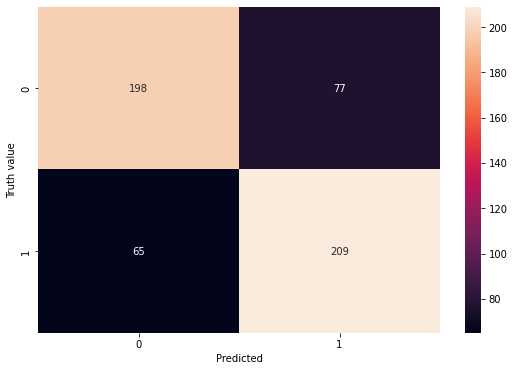

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
plt.figure(figsize=(9,6))
sn.heatmap(g_cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth value')

In [ ]:
acc=(198+209)/(198+77+65+209)
print(" Accuracy : {0:.2f}".format(acc*100))

 Accuracy : 74.13


In [ ]:
aT.extract_features_and_train(['train/COVID','train/HEALTHY'], 1.0, 1.0, aT.shortTermWindow, aT.shortTermStep, "randomforest", "randomforest_model", False, use_smote=True)

Streaming output truncated to the last 5000 lines.
Analyzing file 35 of 2479: train/COVID/0e2f8fe3-12aa-464f-a4cc-312efa425b98.wav
Analyzing file 36 of 2479: train/COVID/0eba0c0a-5609-4777-903d-b15292798250.wav
Analyzing file 37 of 2479: train/COVID/0ebb8b25-3a7e-4018-81c6-c93c832fa769.wav
Analyzing file 38 of 2479: train/COVID/0f8d80f9-700e-4069-924d-e15f29d7c19a.wav
Analyzing file 39 of 2479: train/COVID/0fbbcd89-d79a-49ec-b207-c0f2f32d8d50.wav
Analyzing file 40 of 2479: train/COVID/0ff8a246-cc95-42fe-8e5a-4243c274793e.wav
Analyzing file 41 of 2479: train/COVID/0l20TKQIqBOGwH8Tcr2iD3SRWRv1-s-.wav
Analyzing file 42 of 2479: train/COVID/0mGUoJiJnuhfNodzOrMwjcGftPD2-s-.wav
Analyzing file 43 of 2479: train/COVID/0nP3dtfFxhMihttAMq1eoho5KaU2-s-.wav
Analyzing file 44 of 2479: train/COVID/0pqMnxeSybfQnGV9nHW3P69FSzE3-s-.wav
Analyzing file 45 of 2479: train/COVID/10344906-5f7c-4d1d-93a8-56585cc33b2f.wav
Analyzing file 46 of 2479: train/COVID/105d18a9-f281-4e4c-bb7d-1ad9885696c9.wav
Analyzing

[[192  83]
 [ 53 221]]
[0.6981818181818182, 0.8065693430656934] [0.7836734693877551, 0.7269736842105263] [0.7384615384615384, 0.764705882352941] 0.7515837104072397 0.7522768670309654


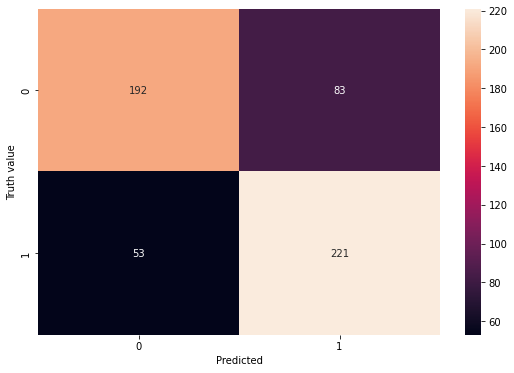

In [ ]:
r_cm, thr_prre, pre, rec, thr_roc, fpr, tpr = aT.evaluate_model_for_folders(["test/COVID","test/HEALTHY"], "randomforest_model", "randomforest","COVID")
plt.figure(figsize=(9,6))
sn.heatmap(r_cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth value')
plt.savefig('rf.png')

In [ ]:
acc=(192+221)/(192+83+53+221)
print(" Accuracy : {0:.2f}".format(acc*100))

 Accuracy : 75.23


In [ ]:
aT.extract_features_and_train(['train/COVID','train/HEALTHY'], 1.0, 1.0, aT.shortTermWindow, aT.shortTermStep, "svm", "svm_model", use_smote=True)

Streaming output truncated to the last 5000 lines.
Analyzing file 47 of 2479: train/COVID/10aed3ae-9ec1-4041-bac6-90b1d4634aee.wav
Analyzing file 48 of 2479: train/COVID/111ccb19-92b9-43e2-b44a-38cde5bf0ca5.wav
Analyzing file 49 of 2479: train/COVID/11237f1a-3eb2-4cf7-80f7-116df4b1699a.wav
Analyzing file 50 of 2479: train/COVID/126b940c-b6c6-4d3d-adc2-92aafab911b4.wav
Analyzing file 51 of 2479: train/COVID/128aac08-4a43-4a36-ac34-5f294d90ca2e.wav
Analyzing file 52 of 2479: train/COVID/1357788c-fd94-45ff-b31d-da0cda859731.wav
Analyzing file 53 of 2479: train/COVID/139P5XQHCAPJlxTo53QLd6FviL82-s-.wav
Analyzing file 54 of 2479: train/COVID/13b55d58-ad6d-4cb4-933e-80622a4ff240.wav
Analyzing file 55 of 2479: train/COVID/13bbc1cd-358b-4e90-9a35-31428809eb2a.wav
Analyzing file 56 of 2479: train/COVID/141ad4b1-d9b2-407d-9e48-913915c02b74.wav
Analyzing file 57 of 2479: train/COVID/14c7b709-ac4d-4aee-bdbc-ac51c11a497e.wav
Analyzing file 58 of 2479: train/COVID/14fb399a-c792-43e2-b852-0e776f8a34a

[[176  99]
 [ 61 213]]
[0.64, 0.7773722627737226] [0.7426160337552743, 0.6826923076923077] [0.6875000000000001, 0.7269624573378839] 0.707231228668942 0.7085610200364298


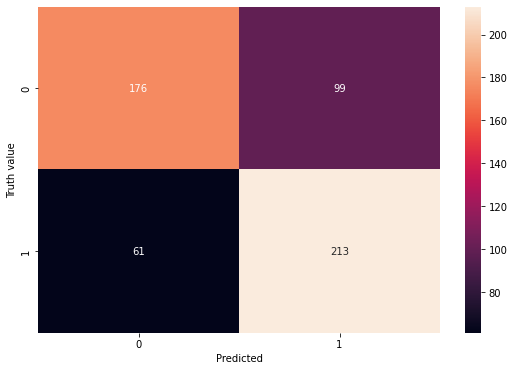

In [ ]:
svm_cm, thr_prre, pre, rec, thr_roc, fpr, tpr = aT.evaluate_model_for_folders(["test/COVID","test/HEALTHY"], "svm_model", "svm","COVID")
plt.figure(figsize=(9,6))
sn.heatmap(svm_cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth value')
plt.savefig('rf.png')

In [ ]:
acc=(176+213)/(176+99+61+213)
print(" Accuracy : {0:.2f}".format(acc*100))

 Accuracy : 70.86


In [ ]:
aT.extract_features_and_train(['train/COVID','train/HEALTHY'], 1.0, 1.0, aT.shortTermWindow, aT.shortTermStep, "svm_rbf", "svm_rbf_model", use_smote=True)

Streaming output truncated to the last 5000 lines.
Analyzing file 47 of 2479: train/COVID/10aed3ae-9ec1-4041-bac6-90b1d4634aee.wav
Analyzing file 48 of 2479: train/COVID/111ccb19-92b9-43e2-b44a-38cde5bf0ca5.wav
Analyzing file 49 of 2479: train/COVID/11237f1a-3eb2-4cf7-80f7-116df4b1699a.wav
Analyzing file 50 of 2479: train/COVID/126b940c-b6c6-4d3d-adc2-92aafab911b4.wav
Analyzing file 51 of 2479: train/COVID/128aac08-4a43-4a36-ac34-5f294d90ca2e.wav
Analyzing file 52 of 2479: train/COVID/1357788c-fd94-45ff-b31d-da0cda859731.wav
Analyzing file 53 of 2479: train/COVID/139P5XQHCAPJlxTo53QLd6FviL82-s-.wav
Analyzing file 54 of 2479: train/COVID/13b55d58-ad6d-4cb4-933e-80622a4ff240.wav
Analyzing file 55 of 2479: train/COVID/13bbc1cd-358b-4e90-9a35-31428809eb2a.wav
Analyzing file 56 of 2479: train/COVID/141ad4b1-d9b2-407d-9e48-913915c02b74.wav
Analyzing file 57 of 2479: train/COVID/14c7b709-ac4d-4aee-bdbc-ac51c11a497e.wav
Analyzing file 58 of 2479: train/COVID/14fb399a-c792-43e2-b852-0e776f8a34a

[[192  83]
 [ 55 219]]
[0.6981818181818182, 0.7992700729927007] [0.7773279352226721, 0.7251655629139073] [0.7356321839080461, 0.7604166666666666] 0.7480244252873564 0.7486338797814208


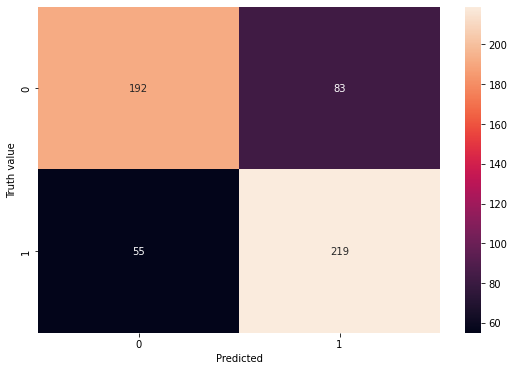

In [ ]:
svmr_cm, thr_prre, pre, rec, thr_roc, fpr, tpr = aT.evaluate_model_for_folders(["test/COVID","test/HEALTHY"], "svm_rbf_model", "svm_rbf","COVID")
plt.figure(figsize=(9,6))
sn.heatmap(svmr_cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth value')
plt.savefig('rf.png')

In [ ]:
acc=(192+219)/(192+83+55+219)
print(" Accuracy : {0:.2f}".format(acc*100))

 Accuracy : 74.86
